<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/2_16_8_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Seed / Epoch Change

In [1]:
# Change
SEED=42

ep = 100  # epochs
probe_ep = 100 # probe training epochs

dense_num = [16, 8, 4]

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

# === 1. Data ===

np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)
tf.keras.utils.set_random_seed(SEED)

## Data Generation

In [3]:
n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))

X_K = X_K.astype('float32')
y1  = y1.astype('float32')

# 2-16-8-4-1

In [4]:
def build_full_model():
    inp = Input(shape=(2,), name='input_full')
    x = Lambda(tf.nn.relu, name='input_relu')(inp)

    h1 = Dense(dense_num[0], activation='relu', name='dense8_1')(x)
    h2 = Dense(dense_num[1], activation='relu', name='dense8_2')(h1)
    h3 = Dense(dense_num[2], activation='relu', name='dense8_3')(h2)

    out = Dense(1, activation='linear', name='out')(h3)

    model = Model(inputs=inp, outputs=out, name='FullModel_16_8_4_1')
    model.compile(optimizer='adam', loss='mse')
    return model

def build_probe_at(backbone_model, stop_layer_name, head_name):
    frozen_out = backbone_model.get_layer(stop_layer_name).output
    head = Dense(1, activation='linear', name=head_name)(frozen_out)
    probe = Model(inputs=backbone_model.input,
                  outputs=head,
                  name=f"Probe_{head_name}")
    probe.compile(optimizer='adam', loss='mse')
    return probe

K_1d = X_K[:, 0]
order = np.argsort(K_1d)
K_sorted = K_1d[order]
y_true_sorted = y1[order, 0]

def plot_bw(model, title):
    y_hat = model.predict(X_K, verbose=0)[:, 0]
    y_hat_sorted = y_hat[order]

    mse = np.mean((y_hat - y1[:, 0])**2)
    print(f"{title} MSE: {mse:.6f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(K_sorted, y_true_sorted,
                s=8, alpha=0.3, c='0.6', label='y = K^3 (data)')
    plt.plot(K_sorted, y_hat_sorted, 'k-', linewidth=2, label=title)
    plt.xlabel('K'); plt.ylabel('prediction')
    plt.title(f"{title} (MSE={mse:.4f})")
    plt.legend()
    plt.grid(True, color='0.8', linestyle=':')
    plt.show()


## Run

Model: "FullModel_16_8_4_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_full (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_1 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_2 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_3 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677 (2.65 KB)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 452 (1.77 KB)

Training probe input_relu
Training probe A
Training probe B
Training probe C
Full model: input_relu(2) → 16 → 8 → 4 → 1 MSE: 0.002445


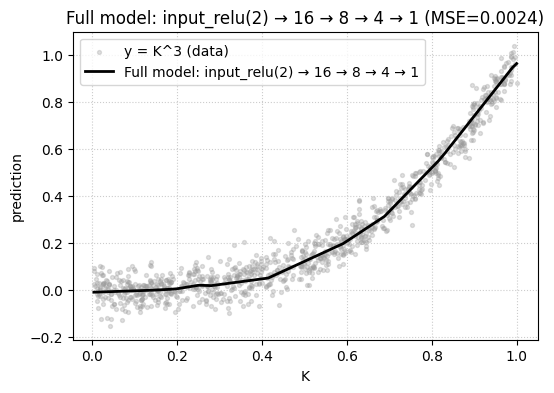

2 → 1 MSE: 0.015083


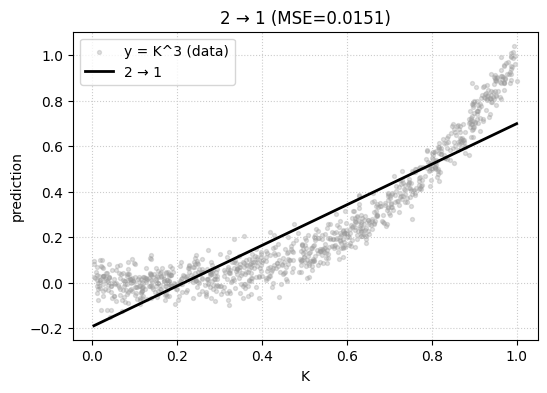

2 → 16 → 1 MSE: 0.003330


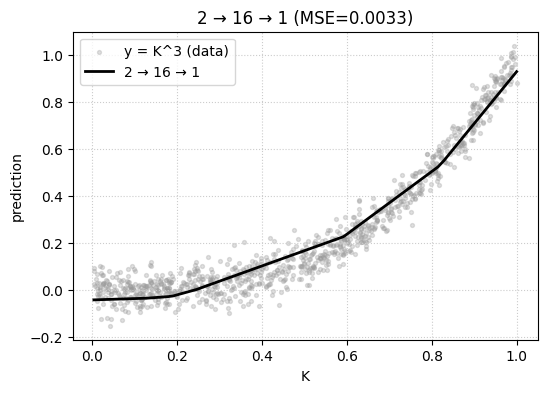

2 → 16 → 8 → 1 MSE: 0.002485


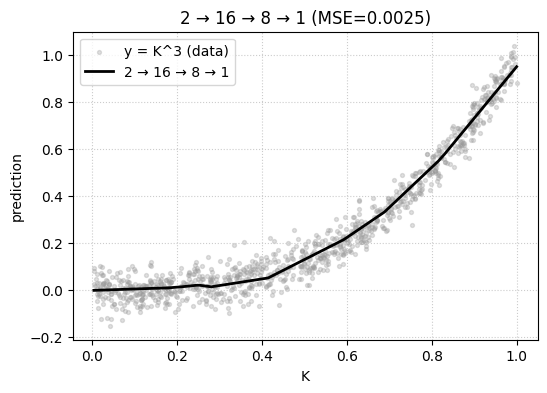

2 → 16 → 8 → 4 → 1 MSE: 0.003733


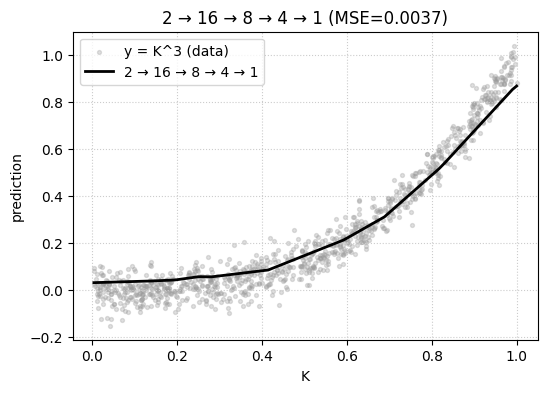

In [5]:
# 2. Full Model
full_model = build_full_model()
full_model.fit(X_K, y1, epochs=ep, batch_size=32, verbose=0)
full_model.summary()

# 3. Backbone
backbone = tf.keras.models.clone_model(full_model)
_ = backbone(tf.zeros((1, 2)))  # build
backbone.set_weights(full_model.get_weights())

for lyr in backbone.layers:
    if lyr.name.startswith('dense8_'):
        lyr.trainable = False

# 4. Probe Generation
probe_relu = build_probe_at(backbone, "input_relu", "head_relu")
probe_A    = build_probe_at(backbone, "dense8_1", "head_A")
probe_B    = build_probe_at(backbone, "dense8_2", "head_B")
probe_C    = build_probe_at(backbone, "dense8_3", "head_C")

# 5. Probe Learning

for m, label in [
    (probe_relu, "input_relu"),
    (probe_A,    "A"),
    (probe_B,    "B"),
    (probe_C,    "C"),
]:
    print(f"Training probe {label}")
    m.fit(X_K, y1, epochs=probe_ep, batch_size=32, verbose=0)

# 6. Result Plotting

plot_bw(full_model, f"Full model: input_relu(2) → {dense_num[0]} → {dense_num[1]} → {dense_num[2]} → 1")
plot_bw(probe_relu, "2 → 1")
plot_bw(probe_A,    f"2 → {dense_num[0]} → 1")
plot_bw(probe_B,    f"2 → {dense_num[0]} → {dense_num[1]} → 1")
plot_bw(probe_C,    f"2 → {dense_num[0]} → {dense_num[1]} → {dense_num[2]} → 1")